## Contamination modelling and detection
### Outline

- How to simulate a contamination event
- Prepare the simulations
- Contamination scenario
- Simulation the even with MSX
- Interval-based contamination detection 
- Contamination detection

### Initialize EPANET Python Toolkit (EPyT)
##### You should always begin with this command to import the toolkit: `from epyt import epanet`

In [ ]:
%pip install epyt

In [1]:
from epyt import epanet

### How to simulate a contamination event
![Description](images/im1.png)



#### Create an arsenite contamination event

In [5]:
Gc = epanet('data/BWSN_Network_1.inp', loadfile=True)   # Load EPANET Input file
Gmsx = Gc.loadMSXFile('data/Arsenite.msx')  # Load MSX File

EPANET version 20200 loaded (EPyT version 1.1.8).
Input File BWSN_Network_1.inp loaded successfully.

Opening MSX file:data/Arsenite.msx
Error 520 - an MSX project is already opened.


##### Arsenite (As3) reacts with Chlorine (Cl2) and produces Arsenate (As5)

### Prepare the simulations

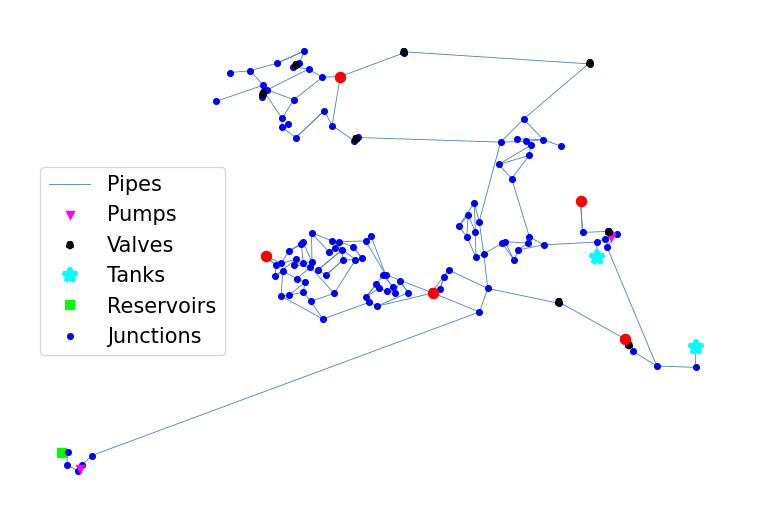

In [7]:
# Sensor locations
sensor_id = {'JUNCTION-17', 'JUNCTION-83', 'JUNCTION-122', 'JUNCTION-31', 'JUNCTION-45'}
sensor_index = [Gc.getNodeIndex(sensor) for sensor in sensor_id]
Gc.plot(highlightnode=sensor_index)
Gc.plot_close() # Close - duplicate plots in jupyter

In [8]:
# Simulation Setup
t_d = 5 # days
Gc.setTimeSimulationDuration(t_d*24*60*60)  #Set simulation duration of 5 days
Gc.setMSXTimeStep(3600) 

### Contamination scenario
##### A contamination scenario needs a location (node), a contaminant concentration and a time profile (start and end time)

In [22]:
injection_node = 'JUNCTION-23'
print('Injection node =', injection_node)

Injection node = JUNCTION-23


In [24]:
injection_conc = 0.05
print('Injection concentration =', injection_conc)

Injection concentration = 0.05


In [25]:
injection_start_time = 150
print('Injection start time =', injection_start_time)

Injection start time = 150


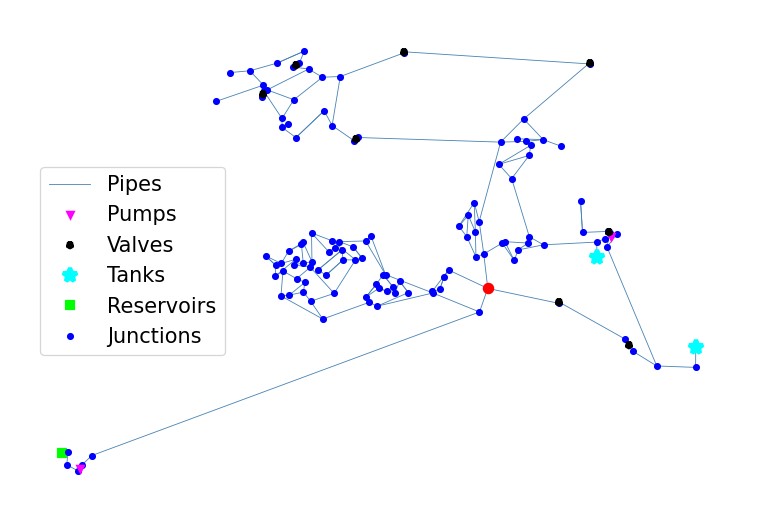

In [26]:
Gc.plot(highlightnode=injection_node);

### Simulation the event with MSX

##### Initialize the contamination vector (binary)

In [30]:
# Import numpy package
import numpy as np

# Initialize the vector
as3_pat = np.zeros(t_d*48)  

# Create the injection pattern 
as3_pat[injection_start_time:] = 1  

print(as3_pat)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


##### Simulate the contamination of water with arsenite

In [32]:
# Specify Arsenite injection source
Gc.setMSXSources(injection_node, 'AsIII', 'SETPOINT', injection_conc, 'AS3PAT')

# Set pattern for injection
Gc.setMSXPattern('AS3PAT',  as3_pat.tolist()) 

# Solve hydraulics and MSX quality dynamics
Qmsx = Gc.getMSXComputedQualityNode(sensor_index)
print(Qmsx.Quality[18][:,0])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.11156434e-04 1.44759849e-03 6.19007896e-02
 2.17553549e-01 1.84922756e-01 7.78967207e-02 3.65537395e-02
 1.99748951e-02 1.23579254e-02 1.10955040e-02 1.07775123e-02
 1.03508492e-02 9.39001475e-03 9.00286674e-03 7.50394231e-03
 7.19454778e-03 6.03301312e-03 6.10387130e-03 7.15471298e-03
 4.84996490e-03 4.26862610e-03 2.62040344e-03 1.61642905e-03
 9.73401554e-03 7.28632609e-02 1.93344665e-01 3.11524997e-01
 4.10820757e-01 4.35756174e-01 4.44127455e-01 4.40470991e-01
 4.49827459e-01 4.52325331e-01 4.52698343e-01 4.50106599e-01
 4.47497525e-01 4.44712884e-01 4.40983115e-01 4.31461565e-01
 4.22413535e-01 4.18452827e-01 2.70649016e-01 1.28087599e-01
 1.08764640e-01 9.71025245e-02 8.71453800e-02 7.88036835e-02
 7.28460955e-02 6.80027772e-02 6.35101794e-02 5.84006463e-02
 5.46782945e-02 5.40909647e-02 1.10432383e-01 1.76290178e-01
 2.35168610e-01 3.46392622e-01 3.71698804e-01 3.82606198e-01
 3.71361083e-01 3.619240

##### Plot the results

In [33]:
import matplotlib.pyplot as plt

for i in sensor_index:
    plt.figure()
    plt.plot(Qmsx.Time[i] / 3600, Qmsx.Quality[i][:,0], label='Cl2 (Chlorine)')
    plt.plot(Qmsx.Time[i] / 3600, Qmsx.Quality[i][:,1], label='As3 (Arsenite)')
    plt.plot(Qmsx.Time[i] / 3600, Qmsx.Quality[i][:,2], label='As5 (Arsenate)')
    plt.legend()
    plt.title(sensor_id[i])
    plt.xlabel('Time (hours)')
    plt.ylabel('Quality')
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (121,)

### Interval-based contamination detection
#### Initialize the simulation

In [37]:
import random

random.seed(1)  

# Load EPANET Network
Gc = epanet('data/BWSN_Network_1.inp')   

EPANET version 20200 loaded (EPyT version 1.1.8).
Input File BWSN_Network_1.inp loaded successfully.



In [41]:
#Load MSX file
Gc.loadMSXFile('data/Arsenite.msx')  
 
# Sensor locations
sensor_id = ['JUNCTION-17', 'JUNCTION-83', 'JUNCTION-122', 'JUNCTION-31', 'JUNCTION-45']
print('sensor_id =', sensor_id)

Opening MSX file:data/Arsenite.msx
Error 520 - an MSX project is already opened.
sensor_id = ['JUNCTION-17', 'JUNCTION-83', 'JUNCTION-122', 'JUNCTION-31', 'JUNCTION-45']


In [44]:
sensor_index = Gc.getNodeIndex(sensor_id)
print(sensor_index) 

[18, 84, 121, 32, 46]


In [45]:
# Set simulation duration for 5 days
t_d = 5 # days
Gc.setTimeSimulationDuration(t_d*24*60*60)  

# Get Network data
demand_pattern = Gc.getPattern()
roughness_coeff = Gc.getLinkRoughnessCoeff()
node_id = Gc.getNodeNameID()

Gc.setMSXTimeStep(3600)

#### Setup incertainties

In [49]:
# Scenarios
Ns = 20 # Number of scenarios to simulate
u_p = 0.20  # Pattern uncertainty
Gc.printv(u_p) # Print value

u_p = 0.2


In [51]:
u_r = 0.20  # Roughness coefficient uncertainty
Gc.printv(u_r) # Print value

u_r = 0.2


#### Create the scenarios - first without contamination, to compute the bounds

In [52]:
max_inj_conc = 0.0
Gc.printv(max_inj_conc)

max_inj_conc = 0.0


In [53]:
# After day 2 (Dt = 30min)
inj_start_time = 2*48   
Gc.printv(inj_start_time)

inj_start_time = 96


In [54]:
# Maximum duration of 12 hours
inj_duration = 24   
Gc.printv(inj_duration)

inj_duration = 24


In [57]:
inj_sc = np.column_stack([
    np.random.randint(1, Gc.NodeCount + 1, size=Ns),     # Injection locations
    max_inj_conc * np.random.rand(Ns),                   # Magnitudes
    np.random.randint(1, 49, size=Ns) + inj_start_time,  # Start times
    np.random.randint(1, inj_duration + 1, size=Ns)      # Durations
])
Gc.printv(inj_sc)

inj_sc = [[ 45.   0.  98.   8.]
 [ 95.   0. 134.  20.]
 [ 56.   0. 109.  22.]
 [127.   0.  98.  11.]
 [  6.   0. 112.  21.]
 [112.   0. 130.  22.]
 [  3.   0. 112.   2.]
 [ 72.   0. 127.  19.]
 [  3.   0. 107.  16.]
 [128.   0. 140.   7.]
 [ 80.   0. 105.   3.]
 [104.   0. 123.  11.]
 [ 18.   0. 129.  22.]
 [ 17.   0. 138.   8.]
 [127.   0. 116.   4.]
 [ 78.   0.  99.  22.]
 [ 15.   0. 103.   1.]
 [115.   0. 101.  17.]
 [ 41.   0. 132.  13.]
 [ 18.   0. 118.  10.]]


#### Run epochs

In [58]:
QQ = []
for i in range(Ns):
    print('Iteration', i + 1)
    
    # Randomize demands
    r_p = -u_p + 2 * u_p * np.random.rand(*demand_pattern.shape)
    new_demand_pattern = demand_pattern + demand_pattern * r_p
    Gc.patterns = new_demand_pattern  # Set new patterns
    
    # Randomize pipe roughness
    r_r = -u_r + 2 * u_r * np.random.rand(*roughness_coeff.shape)
    new_roughness_coeff = roughness_coeff + roughness_coeff * r_r
    Gc.setLinkRoughnessCoeff(new_roughness_coeff) # Set new roughness coefficients
    
    # Simulate quality with randomized hydraulic parameters
    QQ.append(Gc.getMSXComputedQualityNode(sensor_index))  # Solve hydraulics and MSX quality dynamics
    

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20


#### Plot the results without contaminations

In [59]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(len(sensor_index), 1, figsize=(10, 15))

# Iterate over simulations and sensor indices
Qtable = []
for i in range(Ns):
    for j, sensor in enumerate(sensor_index):
        # Plot chlorine concentration for each sensor
        axs[j].plot(QQ[i-1]['Time'] / 24 / 60 / 60, QQ[i]['Quality'][j][:, 0], '-', color=[0, 0.7, 0.9])
        axs[j].grid(True)
        axs[j].set_ylabel('Cl_2 (mg/L)')
        axs[j].set_xlabel('Time (days)')
        Qtable.append(QQ[i]['Quality'][j][:, 0])

# Set titles for each subplot
for i, ax in enumerate(axs):
    ax.set_title(sensor_id[i])

plt.tight_layout()
plt.show()

TypeError: 'EpytValues' object is not subscriptable

#### Compute the intervals for each sensor

In [ ]:
# Initialize upper and lower bound arrays
UBQ = np.zeros((len(Qtable[0]), len(sensor_index)))
LBQ = np.zeros((len(Qtable[0]), len(sensor_index)))

# Iterate over sensor indices
for j in range(len(sensor_index)):
    # Calculate upper bound
    UBQ[:, j] = np.max(Qtable[j], axis=1)
    
    # Calculate lower bound
    LBQ[:, j] = np.min(Qtable[j], axis=1)

#### Plot the intervals

In [ ]:
# Create subplots
fig, axs = plt.subplots(len(sensor_index), 1, figsize=(10, 15))

# Iterate over sensor indices
for j, sensor in enumerate(sensor_index):
    # Plot upper bound
    axs[j].plot(QQ[i]['Time'] / 24 / 60 / 60, UBQ[:, j], 'r-', label='Upper Bound')
    # Plot lower bound
    axs[j].plot(QQ[i]['Time'] / 24 / 60 / 60, LBQ[:, j], 'r-', label='Lower Bound')
    
    # Plot the contamination event simulated earlier
    axs[j].plot(Qmsx['Time'] / 24 / 60 / 60, Qmsx['Quality'][j][:, 0], 'b-', label='Contamination Event')
    
    axs[j].grid(True)
    axs[j].legend()
    axs[j].set_ylabel('Cl_2 (mg/L)')
    axs[j].set_xlabel('Time (days)')
    axs[j].set_title(sensor_id[j])

plt.tight_layout()
plt.show()

## Contamination detection
Compare what the model predicts, with what the (chlorine) sensors measure. If the difference is significantly larger, then put a fault warning.    



$ \\ 
e = y - \hat{y} $

If $ e > \overline{ε} $
then fault flag $ φ(k) = 1$




In [ ]:
# Create subplots
fig, axs = plt.subplots(len(sensor_index), 1, figsize=(10, 15))

# Iterate over sensor indices
for j, sensor in enumerate(sensor_index):
    # Difference between the lower bound and the measured value
    e = LBQ[:, j] - Qmsx['Quality'][j][:, 0]
    
    # Create the phi signal by putting 1 when the error is > 0
    phi = e > 0
    
    # Plot the results
    axs[j].plot(Qmsx['Time'] / 24 / 60 / 60, phi, 'r-')
    axs[j].set_title(sensor_id[j])
    axs[j].set_ylabel('φ')
    axs[j].set_xlabel('Time (days)')
    axs[j].grid(True)

plt.tight_layout()
plt.show()